In [10]:
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

# Number of neurons
N = 10

# Membrane time constant
tau_rc = 20 # 20s

# Refractory period
tau_ref = 1e-3 # 1ms

# Amount of noise
sigma = 0.2

# Construct the neuron model instance
lif_model = nengo.LIFRate(
    tau_rc=tau_rc,
    tau_ref=tau_ref)

# Build a network containing a single ensemble
model = nengo.Network(label='Neurons')
with model:
    # Single neuron ensemble
    neurons = nengo.Ensemble(
        N, dimensions=1, 
        max_rates = Uniform(250, 300),
        neuron_type = lif_model,
        radius = 60)

    # Single connection for decoder computation
    connection = nengo.Connection(
        neurons, neurons, #This is just to generate the decoders
        solver=nengo.solvers.LstsqL2(reg=sigma))

sim = nengo.Simulator(model)

# Fetch the decoders
d = sim.data[connection].weights.T

# Fetch the tuning curves
x, A = tuning_curves(neurons, sim)

# Generate a noisy version of A
A_noisy = A + numpy.random.normal(scale=sigma*numpy.max(A), size=A.shape)

# Decode the value
xhat = numpy.dot(A_noisy, d)

# Compute the RMSE
RMSE = np.sqrt(np.mean(np.square(x - xhat)))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

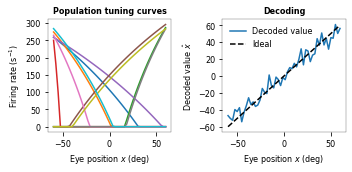

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5))
ax1.plot(x, A)
ax1.set_xlabel('Eye position $x$ (deg)')
ax1.set_ylabel('Firing rate ($\\mathrm{s}^{-1}$)');
ax1.set_title('Population tuning curves')

ax2.plot(x, xhat, label="Decoded value")
ax2.plot(x, x, 'k--', label="Ideal")
ax2.set_xlabel('Eye position $x$ (deg)')
ax2.set_ylabel('Decoded value $\hat x$')
ax2.set_title('Decoding')
ax2.legend()

fig.tight_layout()
fig.savefig("../1d_eye_position.pdf", transparent=True, bbox_inches='tight')